In [1]:
# In this example some time delay surfaces are shown, also
# indicating where the images will be shown

In [2]:
# Load some modules and set some defaults
%matplotlib inline
import grale.lenses as lenses
import grale.images as images
import grale.plotutil as plotutil
import grale.cosmology as cosmology
import grale.feedback as feedback
from grale.constants import *
import numpy as np
import matplotlib.pyplot as plt

V = lambda x,y: np.array([x,y],dtype=np.double)
cosm = cosmology.Cosmology(0.7, 0.3, 0, 0.7)
LI = plotutil.LensInfo

plotutil.setDefaultAngularUnit(ANGLE_ARCSEC)
feedback.setDefaultFeedback("none")

In [3]:
# This is a helper function to create a numY*numX*2 numpy array, containing
# theta-vectors on a grid
def getThetas(bottomLeft, topRight, numX, numY):
    thetas = np.empty((numY,numY,2), dtype=np.double)
    thetas[:,:,0], thetas[:,:,1] = np.meshgrid(np.linspace(bottomLeft[0], topRight[0], numX),
                                               np.linspace(bottomLeft[1], topRight[1], numY))
    return thetas

In [4]:
# For a specific lens, a point source position beta, and redshifts to lens and source,
# this function will create two plots. The first one shows the source position, image
# positions, critical lines and caustics; the second one shows the time delay surface
# (for the specified source position beta), and shows where the images are located.
# If the image is at a minimum of the time delay surface, then it is shown in a blue
# color. Similarly for a maximum a red color is used, and green for a saddle point.
#
# (The way the type of point (minimum, maximum, saddle point) is determined is not very
# robust, it breaks quite easily)
def plotTDSurface(lens, beta, zd, zs):
    Ds = cosm.getAngularDiameterDistance(zs)
    Dds = cosm.getAngularDiameterDistance(zd, zs)

    # With this helper function we'll check the inverse magnification at the specified
    # points, throw out the invalid (NaN) ones, and also discard the very highly demagnified
    # ones
    def filterImages(points, maxInvMag):
        invMag = lens.getInverseMagnification(Ds, Dds, points)
        isNormal = np.logical_not(np.isnan(invMag))
        points = points[isNormal]
        invMag = invMag[isNormal]

        idx = np.where(abs(invMag) < maxInvMag)
        return points[idx]

    # Estimate the plot scale for the lens, and construct a lensInfo dict in which
    # various information can be cached.
    s = plotutil.estimatePlotScale(lens, Dds/Ds)
    lensInfo = LI(lens, size=2*s, Ds=Ds, Dds=Dds, numxy=1023)
    
    # Create the plot of the source, images, critical lines and caustics
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plotutil.plotImagePlane(lensInfo)
    plt.plot(beta[0]/ANGLE_ARCSEC, beta[1]/ANGLE_ARCSEC, 'o', color='green')
    
    imagePlane = lensInfo.getImagePlane()
    imgTheta = filterImages(np.array(imagePlane.traceBeta(beta)), 1e20)
    plt.plot(imgTheta[:,0]/ANGLE_ARCSEC, imgTheta[:,1]/ANGLE_ARCSEC, 'o', color='white')
    
    # For a grid of theta values, calculate the time delay, and show this
    # as a contour map
    thetaGrid = getThetas([-s,-s], [s, s], 128, 128)
    tdValues = lens.getTimeDelay(zd, Ds, Dds, thetaGrid, beta)
    
    plt.subplot(1,2,2)
    plt.contour(thetaGrid[:,:,0]/ANGLE_ARCSEC, thetaGrid[:,:,1]/ANGLE_ARCSEC, tdValues/(60*60*24), 100)
    
    # To estimate the type of image, we'll calculate the difference in time delay
    # value for neighbouring points along x and y direction. 
    td0 = lens.getTimeDelay(zd, Ds, Dds, imgTheta, beta)
    t1 = imgTheta.copy()
    d = s/100.0
    t1[:,0] += d
    t2 = imgTheta.copy()
    t2[:,1] += d
    
    tdx = lens.getTimeDelay(zd, Ds, Dds, t1, beta)-td0
    tdy = lens.getTimeDelay(zd, Ds, Dds, t2, beta)-td0
    
    for i in range(len(imgTheta)):
        if tdx[i] > 0 and tdy[i] > 0: # minimum
            color = "blue"
        elif tdx[i] < 0 and tdy[i] < 0: # maximum
            color = "red"
        else: # saddle point
            color = "green"
            
        plt.plot(imgTheta[i,0]/ANGLE_ARCSEC, imgTheta[i,1]/ANGLE_ARCSEC, 'o', color=color)

In [5]:
# Set some parameters for the lens, and try a few different lens types
zd = 0.7
zs = 2.0
Dd = cosm.getAngularDiameterDistance(zd)

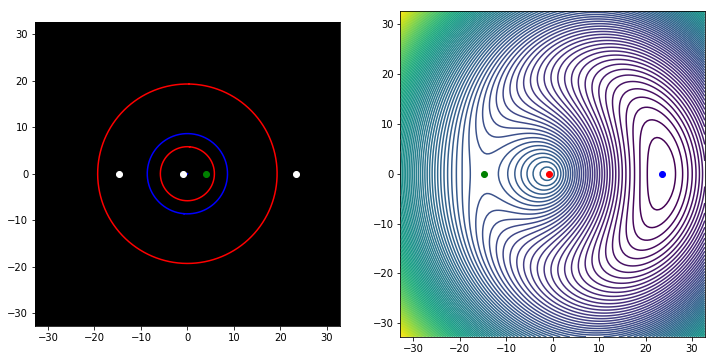

In [6]:
# An NFW lens
lens = lenses.NFWLens(Dd, { "rho_s":1e-21, "theta_s": 18*ANGLE_ARCSEC })
plotTDSurface(lens, V(4,0)*ANGLE_ARCSEC, zd, zs)

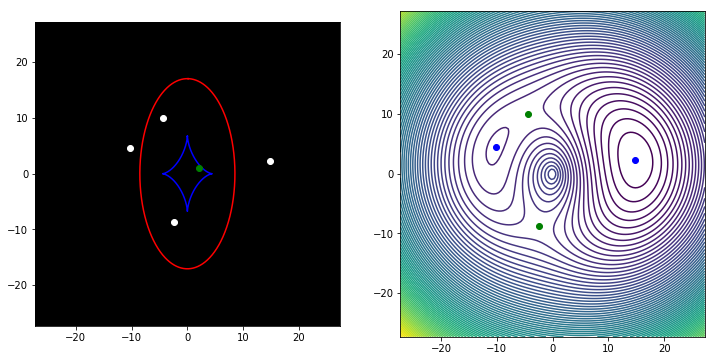

In [7]:
# An SIE lens
lens = lenses.SIELens(Dd, { "velocityDispersion": 900000, "ellipticity": 0.5 })
plotTDSurface(lens, V(2,1)*ANGLE_ARCSEC, zd, zs)

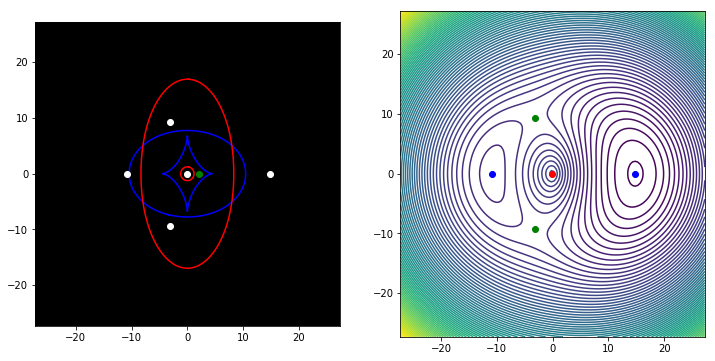

In [8]:
# An NSIE lens
lens = lenses.NSIELens(Dd, { "velocityDispersion": 900000, "ellipticity": 0.5, "coreRadius": 0.1*ANGLE_ARCSEC })
plotTDSurface(lens, V(2,0)*ANGLE_ARCSEC, zd, zs)

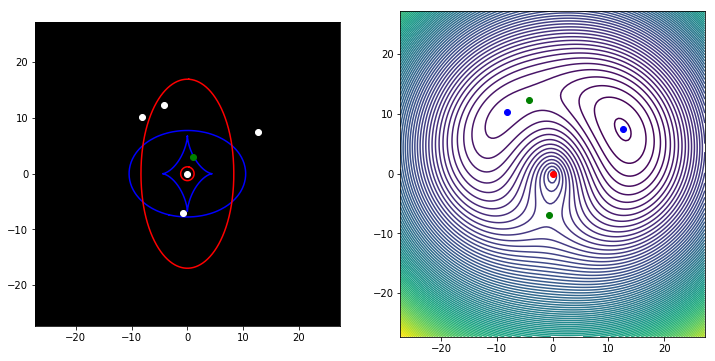

In [9]:
# Same lens, different source position
lens = lenses.NSIELens(Dd, { "velocityDispersion": 900000, "ellipticity": 0.5, "coreRadius": 0.1*ANGLE_ARCSEC })
plotTDSurface(lens, V(1,3)*ANGLE_ARCSEC, zd, zs)